In this [experiment](Finetuning-ViT-multilabel-image-classification.ipynb), fine-tuned a Swin Transformer model, specifically `swin_s3_base_224` from the `timm` library, for multi-label image classification using the Pascal VOC 2007 dataset, achieving an improvement in validation ROC AUC from 72% to 99% after just 5 epochs. (I followed the data preprocessing and training steps in this [tutorial](https://colab.research.google.com/github/johko/computer-vision-course/blob/main/notebooks/Unit%203%20-%20Vision%20Transformers/fine-tuning-multilabel-image-classification.ipynb#scrollTo=7c64af09), but wrote my own scripts.)

The Swin Transformer is a variant of the Vision Transformer (ViT) designed to overcome some of the limitations of the original ViT, such as the fixed size of input patches.

This quick convergence was only possible with learning rate of 2e-4. I experimented with other different learning rates, at which the model would not converge to an acceptable ROC AUC, even at the learning rate of 5e-4 which appears quite close to the 2e-4 learning rate.

The model was fine-tuned using a cosine learning rate schedule, and performance is evaluated using metrics like ROC AUC, calculated via Hugging Face's `evaluate` library.

![loss_plot.png](loss_plot.png)

![roc_auc_plot.png](roc_auc_plot.png)

![predictions.png](predictions.png)

In [1]:
import numpy as np
import torch


# so that the representation of a tensor in debugging includes the shape
normal_repr = torch.Tensor.__repr__ 
torch.Tensor.__repr__ = lambda self: f"{self.shape}_{normal_repr(self)}"  


# Loading & previewing the dataset

In [2]:
from datasets import load_dataset

dataset_id = "fuliucansheng/pascal_voc"
model_checkpoint = "swin_s3_base_224"

dataset_original = load_dataset(dataset_id, name="voc2007_main")
dataset_original

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 2501
    })
    validation: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 2510
    })
    test: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 4952
    })
})

In [3]:
class_names = [
    "Aeroplane","Bicycle","Bird","Boat","Bottle",
    "Bus","Car","Cat","Chair","Cow","Diningtable",
    "Dog","Horse","Motorbike","Person",
    "Potted plant","Sheep","Sofa","Train","Tv/monitor"
]

In [4]:
label2id = {label: i for i, label in enumerate(class_names)}
id2label = {i: label for i, label in enumerate(class_names)}

In [5]:
dataset_original["train"].features

{'id': Value(dtype='int32', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'height': Value(dtype='int32', id=None),
 'width': Value(dtype='int32', id=None),
 'classes': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'objects': Sequence(feature={'bboxes': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), 'classes': ClassLabel(names=['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'background', 'borderingregion'], id=None), 'difficult': Value(dtype='int32', id=None)}, length=-1, id=None)}

In [6]:
# some testing
','.join([id2label[class_id] for class_id in dataset_original["train"][1]['classes']])


'Horse,Person'

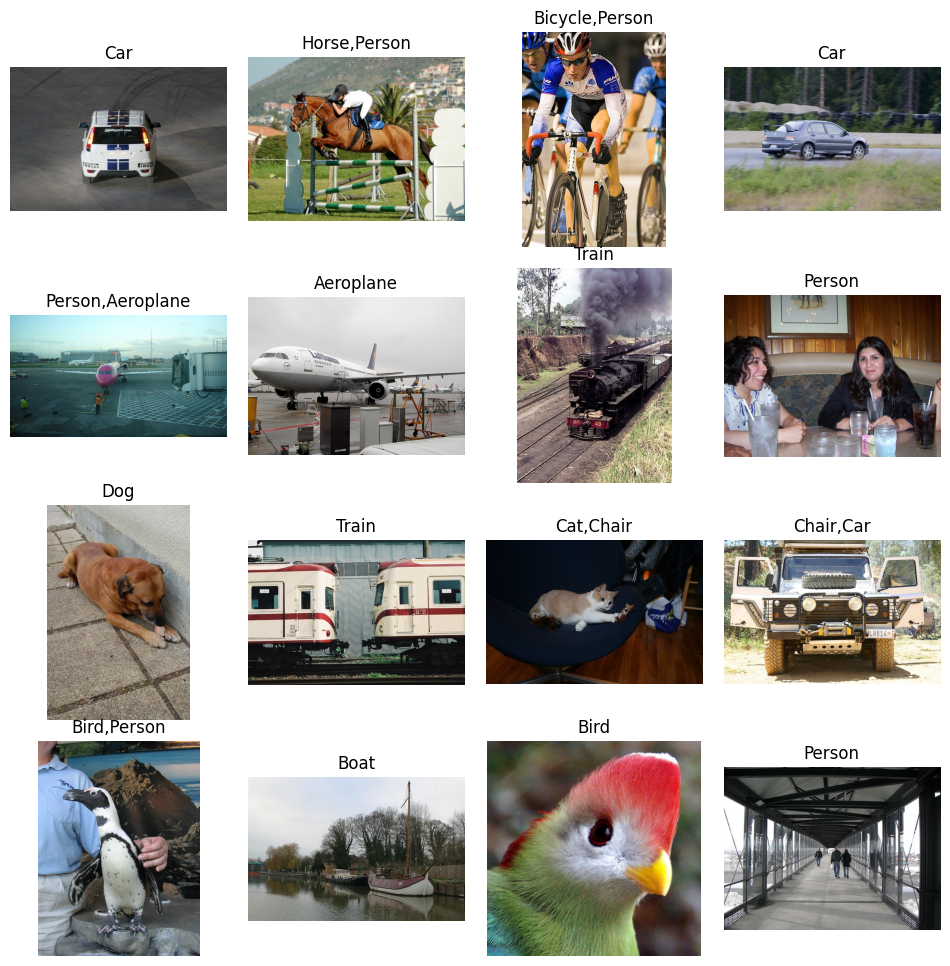

In [62]:
import matplotlib.pyplot as plt
from PIL import Image

rows, cols = 4, 4

def preview_images(dataset, rows=4, cols=4, labels=None):
    fig = plt.figure(figsize=(rows * 3, cols * 3))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(dataset[i]["image"])
        if labels is None:
            label = ','.join([id2label[class_id] for class_id in dataset_original["train"][i]['classes']])
        else:
            label = labels[i]
        ax.set_title(label)
        ax.axis("off")
        
preview_images(dataset_original["train"], rows, cols)


In [8]:
dataset_original["train"].features

{'id': Value(dtype='int32', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'height': Value(dtype='int32', id=None),
 'width': Value(dtype='int32', id=None),
 'classes': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'objects': Sequence(feature={'bboxes': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), 'classes': ClassLabel(names=['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'background', 'borderingregion'], id=None), 'difficult': Value(dtype='int32', id=None)}, length=-1, id=None)}

In [9]:
import torchvision.transforms as transforms
from PIL import Image

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406,], std=[.229, .224, .225]),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(degrees=30),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406,], std=[.229, .224, .225]),
])

In [11]:
from datasets import DatasetDict
dataset_mini = DatasetDict({
    "train": dataset_original["train"],  # .select(range(10)),
    "valid": dataset_original["validation"],  #.select(range(2)),
    }
)
dataset_mini

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 2501
    })
    valid: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 2510
    })
})

In [12]:
dataset_train = dataset_mini["train"]
dataset_valid = dataset_mini["valid"]

In [13]:
def process_dataset_train(batch):
    batch["image"] = [image.convert("RGB") for image in batch["image"]]
    batch["pixel_values"] = [train_transform(image) for image in batch["image"]]
    batch["labels"] = [torch.nn.functional.one_hot(torch.LongTensor(class_list), num_classes=20).sum(axis=0) for class_list in batch["classes"]]
    return batch
    
    
def process_dataset_valid(batch):
    batch["image"] = [image.convert("RGB") for image in batch["image"]]
    batch["pixel_values"] = [valid_transform(image) for image in batch["image"]]
    batch["labels"] = [torch.nn.functional.one_hot(torch.LongTensor(class_list), num_classes=20).sum(axis=0) for class_list in batch["classes"]]
    return batch


In [14]:
dataset_train_w_transform = dataset_train.with_transform(process_dataset_train)
dataset_valid_w_transform = dataset_valid.with_transform(process_dataset_valid)

In [15]:
def collate_fn(batch):
    collated = {
        "pixel_values": torch.stack([example["pixel_values"] for example in batch]),
        "labels": torch.stack([example["labels"] for example in batch])
    }
    return collated

# Set up the data loader

In [16]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    dataset_train_w_transform,
    batch_size=batch_size,
    # shuffle=True,
    collate_fn=collate_fn
)

valid_loader = torch.utils.data.DataLoader(
    dataset_valid_w_transform,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
)

# Set up the model

In [28]:
model2 = model

In [29]:
from timm import create_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
model = create_model(
    model_checkpoint,
    pretrained=True,
    num_classes=20
).to(device)
print(f"Using: {device}")

Using: cuda


In [30]:
# let's count number of params
def param_count(model):
    params = [(p.numel(), p.requires_grad) for p in model.parameters()]
    trainable = sum([count for count, trainable in params if trainable])
    total = sum([count for count, _ in params])
    frac = (trainable / total) * 100
    return total, trainable, frac

In [31]:
print(param_count(model))

(70372142, 70372142, 100.0)


## Testing the model pre-finetuning (should get poorer performance)

# Training


## Set-up: optimizer, lr scheduler, logging/eval params

In [34]:
import tqdm
from transformers import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(params=model.parameters(), lr=2e-4, weight_decay=0.02)

num_epochs = 5
gradient_accumulation_batches = 1
logging_steps = 25
eval_steps = 60

# each "step" consists of several batches that were accumulated
total_training_steps = len(train_loader) // gradient_accumulation_batches * num_epochs

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * len(train_loader)),
    num_training_steps=total_training_steps
)

loss_fn = torch.nn.BCEWithLogitsLoss()

## Training loop

In [35]:
import evaluate

train_metric = evaluate.load('roc_auc', 'multilabel')
completed_steps = 0
currently_accumulated_losses = []
array_train_roc_auc = []
array_val_roc_auc = []
array_train_loss = []
array_val_loss = []

with tqdm.tqdm(desc="Training progress",
               total=total_training_steps,
               unit="steps") as pbar:
    for epoch in range(0, 0 + num_epochs):
        for batch_idx, batch in enumerate(train_loader):
            # pass the inputs through the model
            model.train()
            logits = model(batch["pixel_values"].to(device))
            loss_this_batch = loss_fn(logits, batch["labels"].float().to(device))
            
            # backward pass
            loss_this_batch.backward()
            # save the loss value to the currently-accumulated array
            currently_accumulated_losses.append(loss_this_batch)
            
            train_metric.add_batch(references=batch["labels"], prediction_scores=logits)
            
            # if logging step: 
            if (batch_idx + 1) % (gradient_accumulation_batches * logging_steps) == 0:
                accumulated_loss = torch.stack(currently_accumulated_losses).mean().item()
                print({
                    "completed_steps": completed_steps,
                    "train loss (last accumulation)": accumulated_loss
                }, "\n")
                # array_train_loss.append( (completed_steps, accumulated_loss) )
                
            # if accumulation step: update the optimizer, scheduler, "completed_steps" value, update progress bar
            if (batch_idx + 1) % gradient_accumulation_batches == 0:
                optimizer.step()
                optimizer.zero_grad()
                lr_scheduler.step()
                completed_steps += 1
                pbar.update(1)
                accumulated_loss = torch.stack(currently_accumulated_losses).mean().item()
                array_train_loss.append( (completed_steps, accumulated_loss) )
                currently_accumulated_losses = []
            
            # if eval step:
            if (batch_idx + 1) % (gradient_accumulation_batches * eval_steps) == 0:
                val_loss = 0
                val_metric = evaluate.load('roc_auc', 'multilabel')
                # validation loop
                for batch_idx, eval_batch in enumerate(valid_loader):
                    model.eval()
                    with torch.no_grad():
                        val_logits = model(eval_batch["pixel_values"].to(device))
                    val_loss_this_batch = loss_fn(val_logits, eval_batch["labels"].float().to(device))
                    val_loss += val_loss_this_batch.item()
                    val_metric.add_batch(references=eval_batch["labels"], prediction_scores=val_logits)
                    
                avg_val_loss = val_loss / len(valid_loader)
                val_roc_auc = val_metric.compute(average='micro')['roc_auc']
                print({
                    "completed_steps": completed_steps,
                    "val loss": avg_val_loss,
                    "val ROC AUC": val_roc_auc,
                }, "\n")
                array_val_loss.append( (completed_steps, avg_val_loss) )
                array_val_roc_auc.append( (completed_steps, val_roc_auc) )
                    
        train_roc_auc = train_metric.compute(average='micro')['roc_auc']
        print(f"Epoch {epoch+1}. Train_roc_auc: {train_roc_auc}")
        array_train_roc_auc.append( (completed_steps, train_roc_auc) )
        
        
            
                


Training progress:   6%|▋         | 25/395 [00:33<08:12,  1.33s/steps]

{'completed_steps': 24, 'train loss (last accumulation)': 0.22143593430519104} 



Training progress:  13%|█▎        | 50/395 [01:07<07:53,  1.37s/steps]

{'completed_steps': 49, 'train loss (last accumulation)': 0.21271316707134247} 



Training progress:  15%|█▌        | 60/395 [01:21<07:38,  1.37s/steps]

{'completed_steps': 60, 'val loss': 0.2269226103266583, 'val ROC AUC': 0.7274415411196513} 



Training progress:  19%|█▉        | 75/395 [02:26<07:45,  1.45s/steps]  

{'completed_steps': 74, 'train loss (last accumulation)': 0.19970934092998505} 



Training progress:  20%|██        | 79/395 [02:30<05:31,  1.05s/steps]

Epoch 1. Train_roc_auc: 0.6886574659306041


Training progress:  26%|██▋       | 104/395 [03:05<06:37,  1.37s/steps]

{'completed_steps': 103, 'train loss (last accumulation)': 0.16733743250370026} 



Training progress:  33%|███▎      | 129/395 [03:39<06:02,  1.36s/steps]

{'completed_steps': 128, 'train loss (last accumulation)': 0.14270272850990295} 



Training progress:  35%|███▌      | 139/395 [03:53<05:50,  1.37s/steps]

{'completed_steps': 139, 'val loss': 0.12006182270714, 'val ROC AUC': 0.9481224215390638} 



Training progress:  39%|███▉      | 154/395 [04:58<05:52,  1.46s/steps]  

{'completed_steps': 153, 'train loss (last accumulation)': 0.08097656071186066} 



Training progress:  40%|████      | 158/395 [05:03<04:08,  1.05s/steps]

Epoch 2. Train_roc_auc: 0.8944880635385878


Training progress:  46%|████▋     | 183/395 [05:38<04:50,  1.37s/steps]

{'completed_steps': 182, 'train loss (last accumulation)': 0.05649296194314957} 



Training progress:  53%|█████▎    | 208/395 [06:12<04:15,  1.37s/steps]

{'completed_steps': 207, 'train loss (last accumulation)': 0.06372229009866714} 



Training progress:  55%|█████▌    | 218/395 [06:26<04:01,  1.36s/steps]

{'completed_steps': 218, 'val loss': 0.06459024279743811, 'val ROC AUC': 0.9858772498381866} 



Training progress:  59%|█████▉    | 233/395 [07:31<03:55,  1.46s/steps]

{'completed_steps': 232, 'train loss (last accumulation)': 0.04592136666178703} 



Training progress:  60%|██████    | 237/395 [07:35<02:45,  1.05s/steps]

Epoch 3. Train_roc_auc: 0.983948526835367


Training progress:  66%|██████▋   | 262/395 [08:10<03:01,  1.37s/steps]

{'completed_steps': 261, 'train loss (last accumulation)': 0.023925794288516045} 



Training progress:  73%|███████▎  | 287/395 [08:45<02:28,  1.37s/steps]

{'completed_steps': 286, 'train loss (last accumulation)': 0.02769610285758972} 



Training progress:  75%|███████▌  | 297/395 [08:58<02:14,  1.37s/steps]

{'completed_steps': 297, 'val loss': 0.050456701011597355, 'val ROC AUC': 0.9913192334332042} 



Training progress:  79%|███████▉  | 312/395 [10:04<02:00,  1.46s/steps]

{'completed_steps': 311, 'train loss (last accumulation)': 0.02476241998374462} 



Training progress:  80%|████████  | 316/395 [10:08<01:23,  1.05s/steps]

Epoch 4. Train_roc_auc: 0.9964690848638788


Training progress:  86%|████████▋ | 341/395 [10:43<01:13,  1.37s/steps]

{'completed_steps': 340, 'train loss (last accumulation)': 0.01371034700423479} 



Training progress:  93%|█████████▎| 366/395 [11:17<00:39,  1.38s/steps]

{'completed_steps': 365, 'train loss (last accumulation)': 0.020075352862477303} 



Training progress:  95%|█████████▌| 376/395 [11:31<00:25,  1.37s/steps]

{'completed_steps': 376, 'val loss': 0.04781616582900663, 'val ROC AUC': 0.9922748970360082} 



Training progress:  99%|█████████▉| 391/395 [12:36<00:05,  1.46s/steps]

{'completed_steps': 390, 'train loss (last accumulation)': 0.01786232925951481} 



Training progress: 100%|██████████| 395/395 [12:41<00:00,  1.93s/steps]

Epoch 5. Train_roc_auc: 0.9987268980851772


# Saving the model

In [42]:
import torch
import os

model_save_dir = '/home/nguyenthuan49/HF-Vision/Finetuning-ViT-multilabel-classification/swin-finetuning-experiment'

# Create the directory if it doesn't exist
os.makedirs(model_save_dir, exist_ok=True)

# Save the model's state dictionary
model_path = os.path.join(model_save_dir, 'model.pth')
torch.save(model.state_dict(), model_path)

# Save the model configuration if you have one
if hasattr(model, 'config'):
    config_path = os.path.join(model_save_dir, 'config.json')
    model.config.to_json_file(config_path)

print(f"Model saved to {model_save_dir}")


Model saved to /home/nguyenthuan49/HF-Vision/Finetuning-ViT-multilabel-classification/swin-finetuning-experiment


# Plotting the loss and accuracy

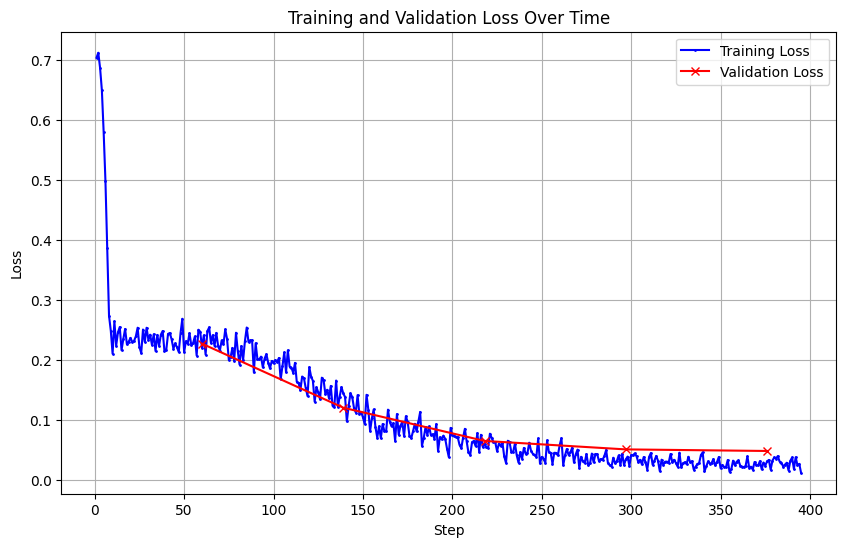

<Figure size 640x480 with 0 Axes>

In [61]:
# Separate steps and loss values for training
train_steps = [x[0] for x in array_train_loss]
train_losses = [x[1] for x in array_train_loss]

# Separate steps and loss values for validation
val_steps = [x[0] for x in array_val_loss]
val_losses = [x[1] for x in array_val_loss]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(train_steps, train_losses, label='Training Loss', color='blue', marker='o', markersize=1)

# Plot validation loss
plt.plot(val_steps, val_losses, label='Validation Loss', color='red', marker='x')

# Add title and labels
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Step')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Save the plot to a file
plt.savefig('/home/nguyenthuan49/HF-Vision/Finetuning-ViT-multilabel-classification/swin-finetuning-experiment/loss_plot.png')


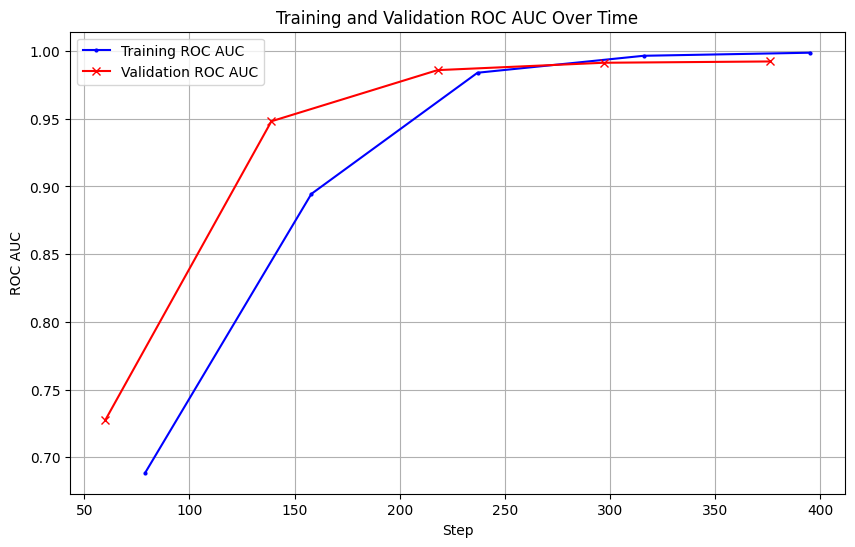

<Figure size 640x480 with 0 Axes>

In [60]:
# Separate steps and ROC AUC values for training
train_steps = [x[0] for x in array_train_roc_auc]
train_roc_auc = [x[1] for x in array_train_roc_auc]

# Separate steps and ROC AUC values for validation
val_steps = [x[0] for x in array_val_roc_auc]
val_roc_auc = [x[1] for x in array_val_roc_auc]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot training ROC AUC
plt.plot(train_steps, train_roc_auc, label='Training ROC AUC', color='blue', marker='o', markersize=2)

# Plot validation ROC AUC
plt.plot(val_steps, val_roc_auc, label='Validation ROC AUC', color='red', marker='x')

# Add title and labels
plt.title('Training and Validation ROC AUC Over Time')
plt.xlabel('Step')
plt.ylabel('ROC AUC')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Save the plot to a file
plt.savefig('/home/nguyenthuan49/HF-Vision/Finetuning-ViT-multilabel-classification/swin-finetuning-experiment/roc_auc_plot.png')


# Inference

In [36]:
dataset_valid_w_transform

Dataset({
    features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
    num_rows: 2510
})

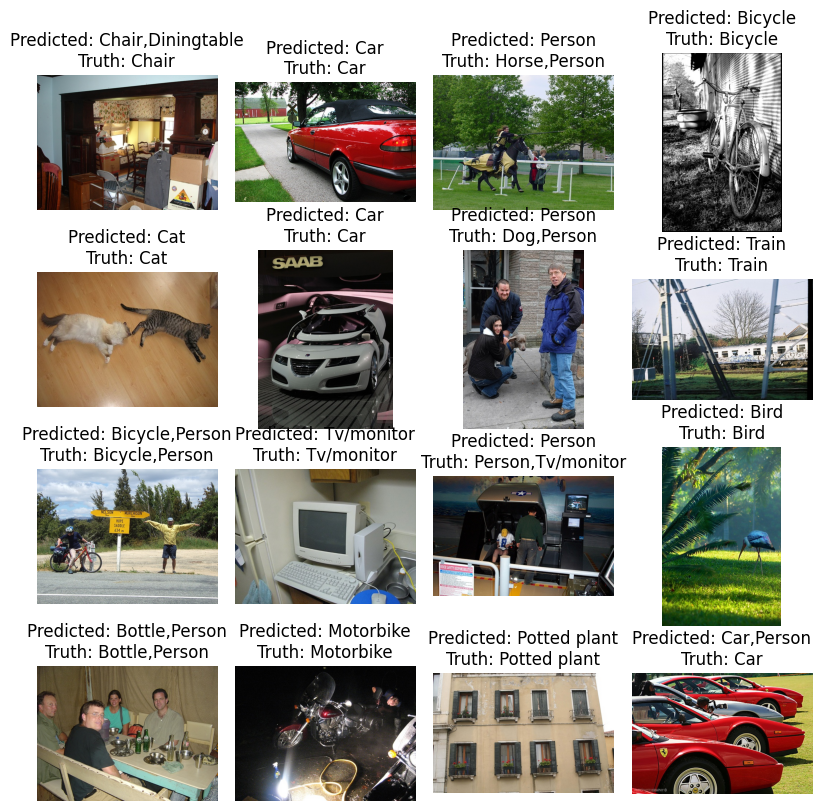

In [57]:
# show some predictions

def show_predictions(valid_dataset, model, rows=4, cols=4, device='cpu'):
    num_to_predict = rows * cols
    # selected_set = valid_dataset.select(range(num_to_predict))
    model.eval()
    with torch.no_grad():
        logits = model(torch.stack(valid_dataset[:]["pixel_values"]).to(device))
    predictions = logits.sigmoid() > 0.5
    predicted_labels = [(','.join([id2label[class_idx] for class_idx in range(len(class_names)) if predictions[i, class_idx]])) 
              for i in range(num_to_predict)]
    ground_truth_classes = [(','.join([id2label[class_idx] for class_idx in range(len(class_names)) if valid_dataset[:]["labels"][i][class_idx]])) 
              for i in range(num_to_predict)]
    labels = [
        f"Predicted: {predicted_labels[i]}\nTruth: {ground_truth_classes[i]}"
        for i in range(num_to_predict)
    ]
    
    preview_images(valid_dataset, rows, cols, labels=labels)
    

show_predictions(dataset_valid_w_transform.select(range(16)), model, rows=4, cols=4, device='cuda')